In [84]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np

# load the census shape and tract
census_shape = gpd.read_file('shape/lda_000a21a_e/lda_000a21a_e.shp')
census_tract = pd.read_csv('csv/census_ontario_selected_columns.csv')

# Store the ontario stats separately
ontario_stats = census_tract.iloc[1]

# Filter for Ontario only
census_shape = census_shape[census_shape['PRUID'] == '35']

# drop PRUID and DGUID as unncessary and convert object to int column
census_shape.drop(columns=['PRUID', 'DGUID'], inplace=True)
census_shape['DAUID'] = census_shape['DAUID'].values.astype(int)

# merge the columns together
census_df = pd.merge(census_tract, census_shape, left_on='ALT_GEO_CODE', right_on='DAUID', how='inner')

# Convert to geodataframe
census_gdf = gpd.GeoDataFrame(census_df, geometry='geometry')

# load the pharmacy data
pharmacy_df = pd.read_csv('csv/Fixed OCP Search.csv')

# Get only active pharmacy
pharmacy_df = pharmacy_df[pharmacy_df['Status'] == 'Active']

# Convert to geodataframe
pharmacy_gpf = gpd.GeoDataFrame(pharmacy_df, geometry=gpd.points_from_xy(pharmacy_df['Longitude'], pharmacy_df['Latitude']))

# load the doctor data
doctor_pf = pd.read_csv('csv/doctors.csv')

# Convert to geodataframe
doctor_gpf = gpd.GeoDataFrame(doctor_pf, geometry=gpd.points_from_xy(doctor_pf['Longitude'], doctor_pf['Latitude']))

In [97]:
census_gdf = gpd.GeoDataFrame(census_df, geometry='geometry')
census_gdf.to_crs('WGS84', inplace=True)

0        7.566347e+06
1        7.561338e+06
2        7.564933e+06
3        7.558741e+06
4        7.561612e+06
             ...     
20463    6.205786e+06
20464    6.210604e+06
20465    6.334170e+06
20466    6.378132e+06
20467    6.139924e+06
Name: geometry, Length: 20468, dtype: float64

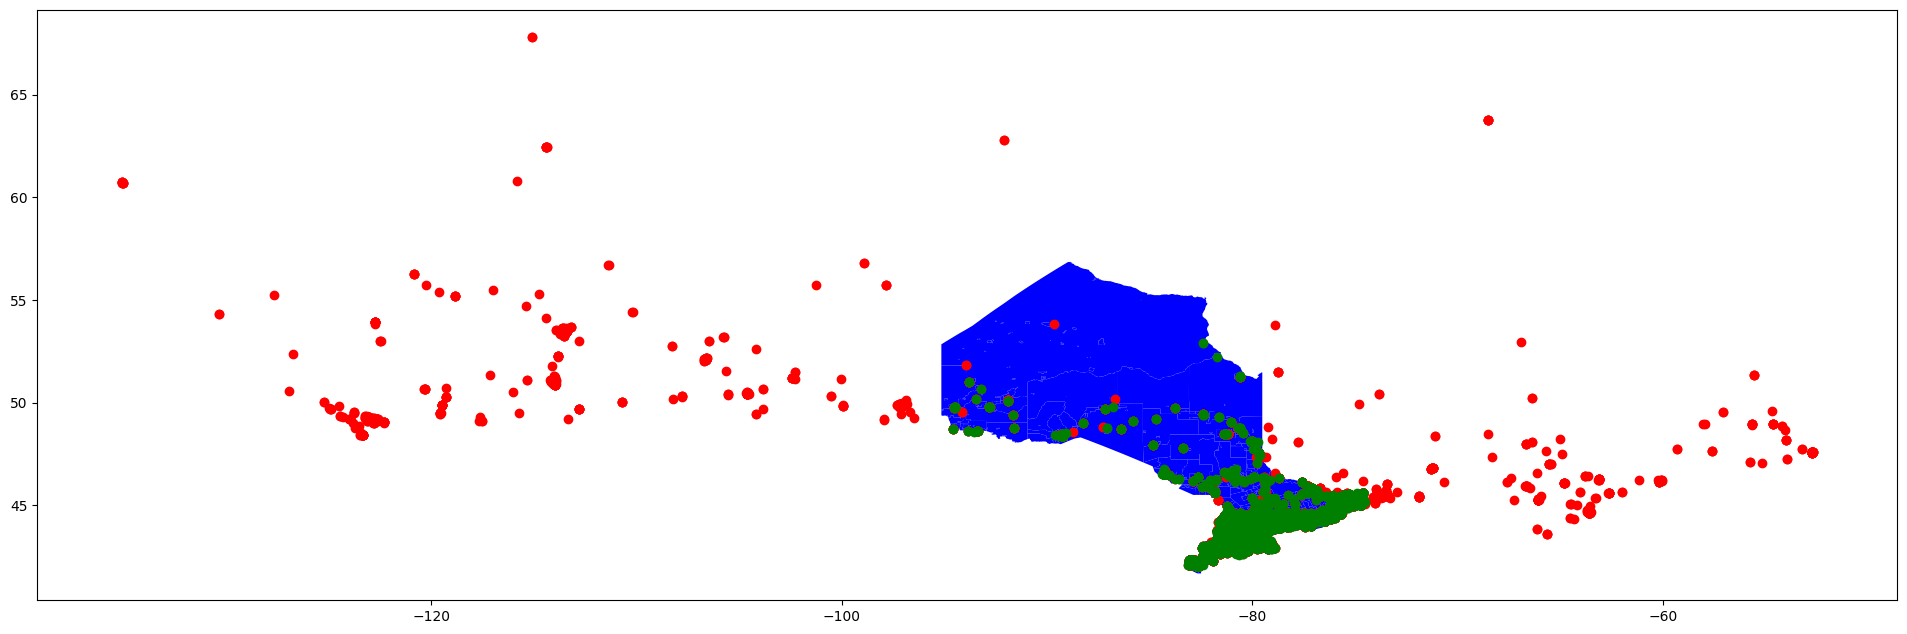

In [93]:
fig, ax = plt.subplots(figsize=(24, 24))

census_gdf.plot(ax=ax, color='blue')
doctor_gpf.plot(ax=ax, color='red')
pharmacy_gpf.plot(ax=ax, color='green')

plt.show()